## Mini Project

In [1]:
import time
import numpy as np

## Feature Extraction - ResNet

In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [3]:
import numpy as np
from numpy.random import RandomState

prng = RandomState(42)
num = 5000
#Extract a subset of 5000 samples from MNIST training
random_permute=prng.permutation(np.arange(0,60000))[0:num]

In [4]:
x = np.zeros((num, 28, 28))
y = np.zeros(num)
for i in range(x.shape[0]):
  x[i] = x_train[random_permute[i]]
  y[i] = y_train[random_permute[i]]

In [5]:
import cv2

def change_size(x):
  x_resize = np.zeros((x.shape[0], 224, 224))
  for i in range(x.shape[0]):
    x_resize[i] = cv2.resize(x[i], (224, 224))

  x_channel = x_resize[:,:,:,np.newaxis]
  x_final = np.concatenate( (x_channel,x_channel), axis=3 )
  x_final = np.concatenate( (x_final,x_channel), axis=3 )
  return x_final

In [6]:
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

x_input = change_size(x)
x_input = preprocess_input(x_input)
res50_base_model = ResNet50(weights='imagenet', include_top=True)
res50_model = Model(inputs=res50_base_model.input, outputs=res50_base_model.get_layer('fc1000').input)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
import time

start = time.time()

res50_feature = res50_model.predict(x_input)
res50_label = y

end = time.time()
end - start

845.329948425293

In [8]:
res50_feature.shape

(5000, 2048)

## Visualize

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.style as style 
import matplotlib.pyplot as plt
import matplotlib

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### PCA of ResNet50

In [15]:
start = time.time()

res50_pca_embedded = PCA(n_components=2).fit_transform(res50_feature)  
res50_pca_embedded.shape

end = time.time()
end - start

0.6710987091064453

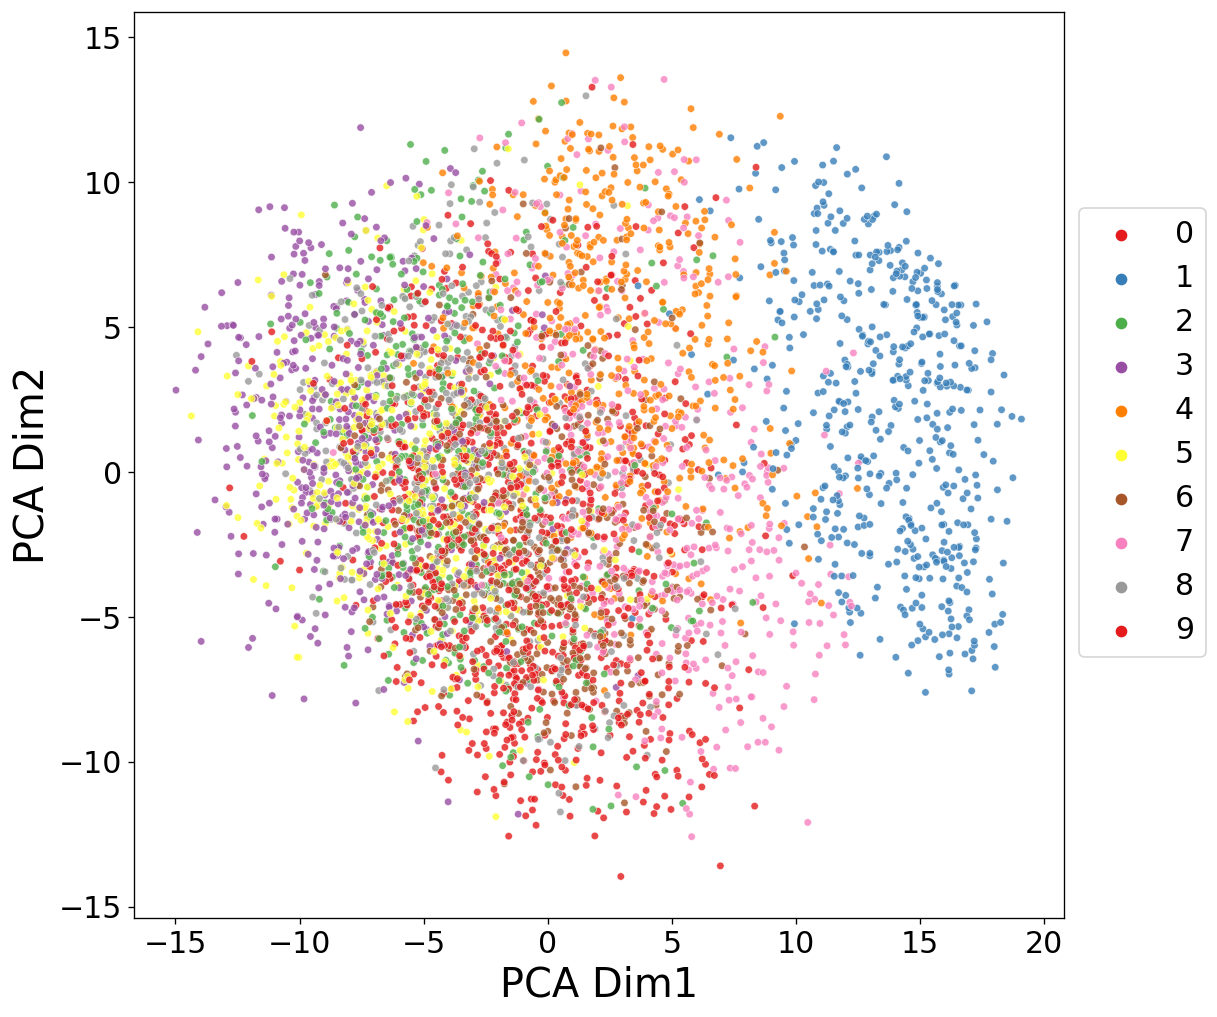

In [86]:
res50_pca_embedded_df = pd.DataFrame(res50_pca_embedded,index=res50_label)
res50_pca_embedded_df = res50_pca_embedded_df.reset_index()
res50_pca_embedded_df['index'] = res50_pca_embedded_df['index'].astype(int)
res50_pca_embedded_df_plot = res50_pca_embedded_df.loc[range(5000),:]
res50_pca_embedded_df_plot.columns = ['Label','PCA Dim1', 'PCA Dim2']
plt.figure(figsize=(10,10),dpi=120)
ax = sns.scatterplot(x='PCA Dim1', y='PCA Dim2',hue='Label',data=res50_pca_embedded_df_plot,
                     palette='Set1',alpha=0.8,s=20,legend='full') # tab10  Set1  husl 
ax.set_xlabel('PCA Dim1', fontsize=24)
ax.set_ylabel('PCA Dim2', fontsize=24)
ax.tick_params(labelsize=18)
# ax.set_title('PCA of ResNet50', fontsize=30, position=(0.5,1.02))
legend = plt.legend(bbox_to_anchor=(1, 0.8),fontsize='18')
plt.show()

### TSNE of ResNet50

In [17]:
start = time.time()

res50_tsne_embedded = TSNE(n_components=2).fit_transform(res50_feature)

end = time.time()
end - start

104.35998868942261

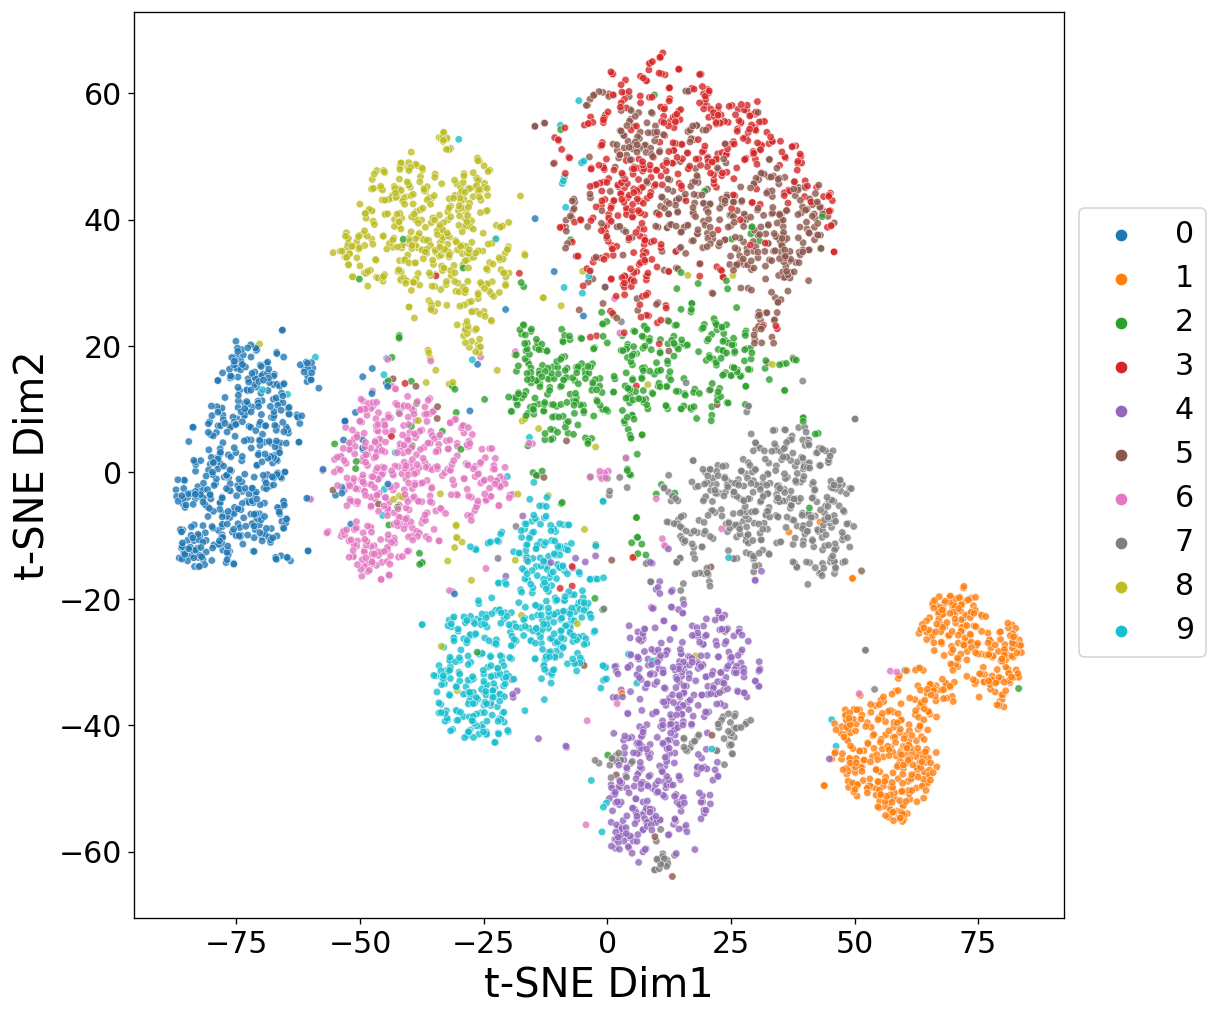

In [87]:
res50_tsne_embedded_df = pd.DataFrame(res50_tsne_embedded,index=res50_label)
res50_tsne_embedded_df = res50_tsne_embedded_df.reset_index()
res50_tsne_embedded_df['index'] = res50_tsne_embedded_df['index'].astype(int)
res50_tsne_embedded_df_plot = res50_tsne_embedded_df.loc[range(5000),:]
res50_tsne_embedded_df_plot.columns = ['Label','tSNE Dim1', 'tSNE Dim2']
plt.figure(figsize=(10,10),dpi=120)
ax = sns.scatterplot(x='tSNE Dim1', y='tSNE Dim2',hue='Label',data=res50_tsne_embedded_df_plot,
                     palette='tab10',alpha=0.8,s=20,legend='full')
ax.set_xlabel('t-SNE Dim1', fontsize=24)
ax.set_ylabel('t-SNE Dim2', fontsize=24)
ax.tick_params(labelsize=18)
# ax.set_title('t-SNE of ResNet50', fontsize=30, position=(0.5,1.02))
legend = plt.legend(bbox_to_anchor=(1, 0.8),fontsize='18')
plt.show()

### Classifications based on features extracted by resnet50

We try 4 different classification methods here.  
-- LDA (LinearDiscriminantAnalysis)  
-- Logistic Regression  
-- SVM  
-- Random Forest  

In [19]:
from sklearn.model_selection import cross_validate

In [76]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

start = time.time()

lda = LinearDiscriminantAnalysis()

lda_results = cross_validate(lda, res50_feature[:5000], res50_label[:5000], cv=3, scoring='accuracy')
lda_results = lda_results['test_score']

end = time.time()
end - start, lda_results

(16.79067373275757, array([0.96640672, 0.95560888, 0.96938776]))

In [77]:
from sklearn.linear_model import LogisticRegression

start = time.time()

logistic_regression = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

logistic_regression_results = cross_validate(logistic_regression, res50_feature[:5000], res50_label[:5000], cv=3, scoring='accuracy')
logistic_regression_results = logistic_regression_results['test_score']

end = time.time()
end - start, logistic_regression_results

d:\program\python\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
d:\program\python\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extr

(3.699310779571533, array([0.97360528, 0.95980804, 0.97058824]))

In [78]:
from sklearn import svm

start = time.time()

linear_svc = svm.LinearSVC()

svm_results = cross_validate(linear_svc, res50_feature[:5000], res50_label[:5000], cv=3, scoring='accuracy')
svm_results = svm_results['test_score']

end = time.time()
end - start, svm_results

d:\program\python\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
d:\program\python\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
d:\program\python\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(18.800714015960693, array([0.97720456, 0.97120576, 0.97959184]))

In [79]:
from sklearn.ensemble import RandomForestClassifier

start = time.time()

random_forest = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)

random_forest_results = cross_validate(random_forest, res50_feature[:5000], res50_label[:5000], cv=3, scoring='accuracy')
random_forest_results = random_forest_results['test_score']

end = time.time()
end - start, random_forest_results

(1.7477188110351562, array([0.86682663, 0.880024  , 0.8697479 ]))

In [80]:
lda_results,logistic_regression_results,svm_results,random_forest_results

(array([0.96640672, 0.95560888, 0.96938776]),
 array([0.97360528, 0.95980804, 0.97058824]),
 array([0.97720456, 0.97120576, 0.97959184]),
 array([0.86682663, 0.880024  , 0.8697479 ]))

In [81]:
lda_results.mean(),logistic_regression_results.mean(),svm_results.mean(),random_forest_results.mean()

(0.9638011173275549,
 0.9680005175435501,
 0.9760007182237022,
 0.8721995096778964)

In [82]:
lda_results.std(),logistic_regression_results.std(),svm_results.std(),random_forest_results.std()

(0.0059192471771192575,
 0.005922452987241481,
 0.0035278416630854575,
 0.005659821953950952)